<a href="https://colab.research.google.com/github/Qaiserfarooq285/Research/blob/main/traditionalSSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# ============================================
# 1) Install + Imports
# ============================================
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cpu


In [4]:
# ============================================
# 2) Simple Discrete State Space Model Layer
# ============================================
class SimpleSSM(nn.Module):
    """
    Implements:
        x_{t+1} = A x_t + B u_t
        y_t     = C x_t + D u_t
    """
    def __init__(self, input_dim, state_dim, output_dim):
        super().__init__()

        self.input_dim = input_dim
        self.state_dim = state_dim
        self.output_dim = output_dim

        # Learnable matrices
        self.A = nn.Parameter(torch.randn(state_dim, state_dim) * 0.1)
        self.B = nn.Parameter(torch.randn(state_dim, input_dim) * 0.1)
        self.C = nn.Parameter(torch.randn(output_dim, state_dim) * 0.1)
        self.D = nn.Parameter(torch.randn(output_dim, input_dim) * 0.1)

    def forward(self, u, x0=None):
        """
        u: (batch, seq_len, input_dim)
        x0: (batch, state_dim) optional
        returns y: (batch, seq_len, output_dim)
        """
        B, T, _ = u.shape

        if x0 is None:
            x = torch.zeros(B, self.state_dim, device=u.device)
        else:
            x = x0

        ys = []
        for t in range(T):
            ut = u[:, t, :]  # (B, input_dim)

            # output
            yt = x @ self.C.T + ut @ self.D.T
            ys.append(yt)

            # next state
            x = x @ self.A.T + ut @ self.B.T

        y = torch.stack(ys, dim=1)
        return y


In [5]:
# ============================================
# 3) Toy Dataset: Cumulative sum task
# ============================================
def generate_data(batch_size=64, seq_len=50, input_dim=1):
    u = torch.randn(batch_size, seq_len, input_dim)
    y = torch.cumsum(u, dim=1)  # target output = running sum
    return u, y


In [6]:
# ============================================
# 4) Train the SSM
# ============================================
input_dim  = 1
state_dim  = 16
output_dim = 1
seq_len    = 50

model = SimpleSSM(input_dim, state_dim, output_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

losses = []
for step in range(500):
    u, y_true = generate_data(batch_size=128, seq_len=seq_len, input_dim=input_dim)
    u, y_true = u.to(device), y_true.to(device)

    y_pred = model(u)
    loss = loss_fn(y_pred, y_true)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if step % 50 == 0:
        print(f"Step {step:04d} | Loss {loss.item():.6f}")


Step 0000 | Loss 27.099106
Step 0050 | Loss 21.723665
Step 0100 | Loss 21.360449
Step 0150 | Loss 21.717257
Step 0200 | Loss 17.240471
Step 0250 | Loss 23.887785
Step 0300 | Loss 22.188370
Step 0350 | Loss 21.023222
Step 0400 | Loss 24.481739
Step 0450 | Loss 23.067165


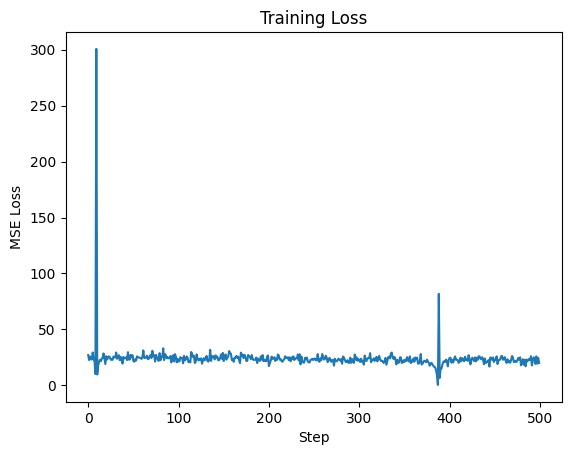

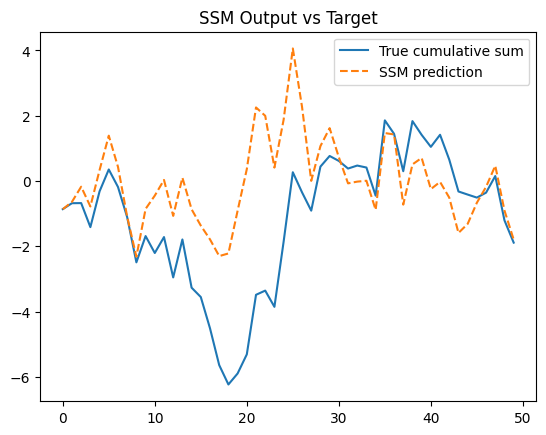

In [7]:
# ============================================
# 5) Plot Results
# ============================================
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("MSE Loss")
plt.show()


# test one batch
u, y_true = generate_data(batch_size=1, seq_len=seq_len, input_dim=input_dim)
u, y_true = u.to(device), y_true.to(device)

with torch.no_grad():
    y_pred = model(u)

u_cpu      = u.cpu().numpy().squeeze()
y_true_cpu = y_true.cpu().numpy().squeeze()
y_pred_cpu = y_pred.cpu().numpy().squeeze()

plt.plot(y_true_cpu, label="True cumulative sum")
plt.plot(y_pred_cpu, "--", label="SSM prediction")
plt.legend()
plt.title("SSM Output vs Target")
plt.show()
